In [ ]:
# Change the directory form the notebook
%cd ..

# Humsa project - Calcium release / Synchronicity

In [2]:
# load all the necessary modules for the analysis
from cellsync.io import *
from cellsync.registration import *
from cellsync.segmentation import *
from cellsync.correlation import *
from cellsync.plot_traces import *
from cellsync.synchronicity import *
from cellsync.to_dataframe import *

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Plot inside the notebook
%matplotlib inline
# this is used for debugging purposes only. allows to reload classes when changed
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt

In [6]:
# General parameters of the plot
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Opening the file

In [ ]:
%cd ..

In [8]:
path = "path/to/file"

In [9]:
# The function metadata will generate a Python dictionaty with some important information
meta = metadata(path)

In [10]:
for key in meta:
    print(key)

sizeT
sizeX
sizeY
dtype
shapeX
shapeY
TimePoint


In [11]:
# open_file will open the file as a numpy stack.
# File should be in subfolder/_channel_1 or 

ch1 = open_file(path, meta, ch="/channel_1")
ch2 = open_file(path, meta, ch="/channel_2")

# Introduction to Numpy

In Python, images are represented as `numpy` arrays. A single-channel, or grayscale, image is a 2D matrix of pixel intensities of shape `(row, column)`. We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`. Multichannel data adds a `channel` dimension in the final position containing color information. 

These conventions are summarized in the table below:


|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Note that, although, some 3D images are constructed with equal resolution in each dimension. In microscopy, data captured in the Z dimension have (usually) lower resolution than in XY. The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.


In [12]:
print("ch1 shape:", ch1.shape)
print("type:", ch1.dtype)
print("Size in bytes:", ch1.nbytes)

ch1 shape: (748, 279, 466)
type: uint16
Size in bytes: 194500944


We need to make sure that the data have the write shape:

In [13]:
if len(ch1)%10!=0:
    to_analyse_max = len(ch1) - len(ch1)%50
else:
    to_analyse_max = len(ch1)

We can also directly choose the part of the data we would like to analyse:

In [14]:
to_analyse_min = 0
#to_analyse_max = 300

In [15]:
#It is possible to select only the first 1000 frames:
ch1 = ch1[to_analyse_min:to_analyse_max]
ch2 = ch2[to_analyse_min:to_analyse_max]
#However, it's important to adjust the metadata
meta['TimePoint'] = meta['TimePoint'][to_analyse_min:to_analyse_max]
meta['sizeT'] = len(meta['TimePoint'])

# Visualization of the data

In [16]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [17]:
@interact(img = fixed(ch1[0]), x=(0,len(ch1)-1), continuous_update=False)
def widget(x):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    ax.imshow(ch1[x,::2,::2])
    plt.show()

interactive(children=(IntSlider(value=349, description='x', max=699), Output()), _dom_classes=('widget-interac…

# Motion correction
First we create a motion correction object (shift) by using phase correlation to identify the relative shift between two similar-sized images.

In [18]:
shifts = list_shift(ch1)

We can plot the result:

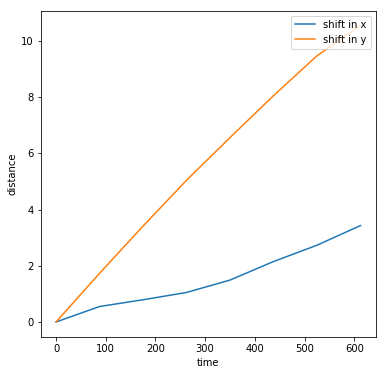

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
x_range = np.arange(0, ch1.shape[0], ch1.shape[0]/len(shifts))
ax.plot(x_range, shifts[:,0], label='shift in x')
ax.plot(x_range, shifts[:,1], label='shift in y')
ax.legend(loc='upper right')
ax.set_ylabel('distance')
ax.set_xlabel('time')

### Using the measured shift, we can now perform motion correction.

In [20]:
reg_ch1 = registration(ch1, shifts)

Cell bellow can be use to inspect in detail the result

Alternatively we can "visually" inspect the result

In [21]:
@interact(img = fixed(reg_ch1[0]), x=(0,len(ch1)-1), continuous_update=False)
def widget(x):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
    ax.imshow(reg_ch1[x,::2,::2])
    plt.show()

interactive(children=(IntSlider(value=349, description='x', max=699), Output()), _dom_classes=('widget-interac…

# Segmentation using SLIC (Simple Linear Iterative Clustering), a K-Means based image segmentation.
[Achanta et al. 2012](https://ieeexplore.ieee.org/document/6205760/)

### The arg "strength" may need to be adjusted (usually between 50 and 300) between experiment if data are over or under segmented

In [22]:
seg, im_reg = slic_segment(reg_ch1, strength=100)

Visualyse the segmentation result:

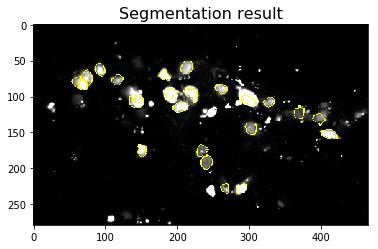

In [23]:
from skimage import exposure, segmentation
p2, p98 = np.percentile(im_reg.astype(np.int16), (2, 98))
new_eq = exposure.rescale_intensity(im_reg.astype(np.int16), in_range=(p2, p98))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segmentation.mark_boundaries(new_eq, seg))
ax.set_title('Segmentation result', fontsize=16)

### Registration channel2 (Ca) using the registration object calculated on ch1

In [24]:
ch2_reg = registration(ch2, shifts)

# Create correlation image
The correlation image for each pixel is computed by averaging the correlation coefficients (taken over time) of each pixel with its four immediate neighbors. Based on [Pnevmatikakis et al. 2016](https://www.cell.com/neuron/abstract/S0896-62731501084-3)

In [25]:
ch2_corr = correlations(ch2_reg)

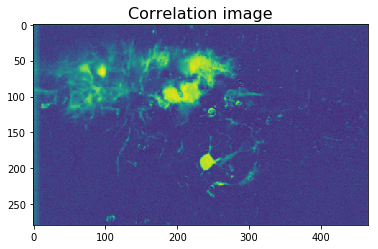

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(ch2_corr)
ax.set_title('Correlation image', fontsize=16)

# Extract ${\Delta F}/F$ fluorescence trace
Based on [Pnevmatikakis et al. 2016](https://www.cell.com/neuron/abstract/S0896-62731501084-3):
${\Delta F}/F$ value at frame i of ROI j-th is computed by subtracting its mean intensity with the 10th percentile of the previous 140 frames and dividing it by the same number. 

In [27]:
d, data, cell_position, labels, regions_ch2 = create_traces(ch2_reg,seg)

# Plot traces
If save=True, data will be save, you cam add an argument path='xx' to enter the directory to where you want to save the result. Plot would be save as 'plot_traces'

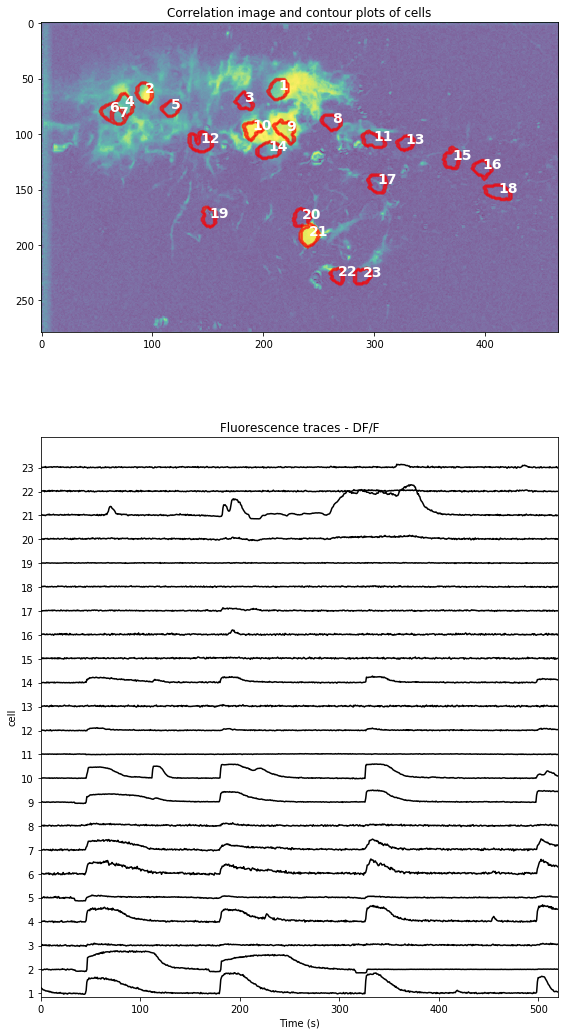

In [28]:
plot_traces(ch2_corr, meta, data, seg, cell_position, labels,
                plot_all = True, ymin=40, ymax=50, tmin=meta["TimePoint"][:], 
            tmax=meta["TimePoint"][:], save=False, path=path)

# Find synchronization and plot
Data are first smooth and then local maxima of calcium signals were detected by the [detect_peaks](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb) function writtend by Marcos Duarte. The spike is then extracted by finding the beginning of the slope.

The synchronicity S, which was defined by [Osswald et al. 2015](https://www.nature.com/articles/nature16071) as
the fraction of the whole number of synchronous cells (NSyn) divided by the number of calcium peaks for the given cell (NCa). In case the cells were not active, a synchronicity of zero was allotted. 
If save=True, data will be save, you cam add an argument path='xx' to enter the directory to where you want to save the result. Plot would be save as 'plot_correlation'

In [29]:
sync_time=4
print("time frame =",  meta["TimePoint"][sync_time]- meta["TimePoint"][0], "sec")

time frame = 3.0 sec


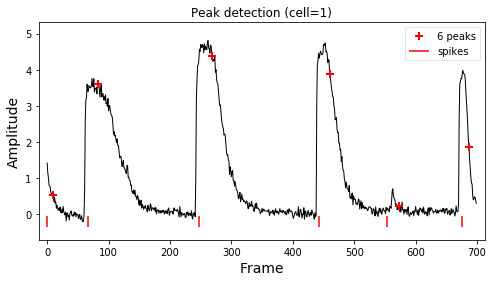

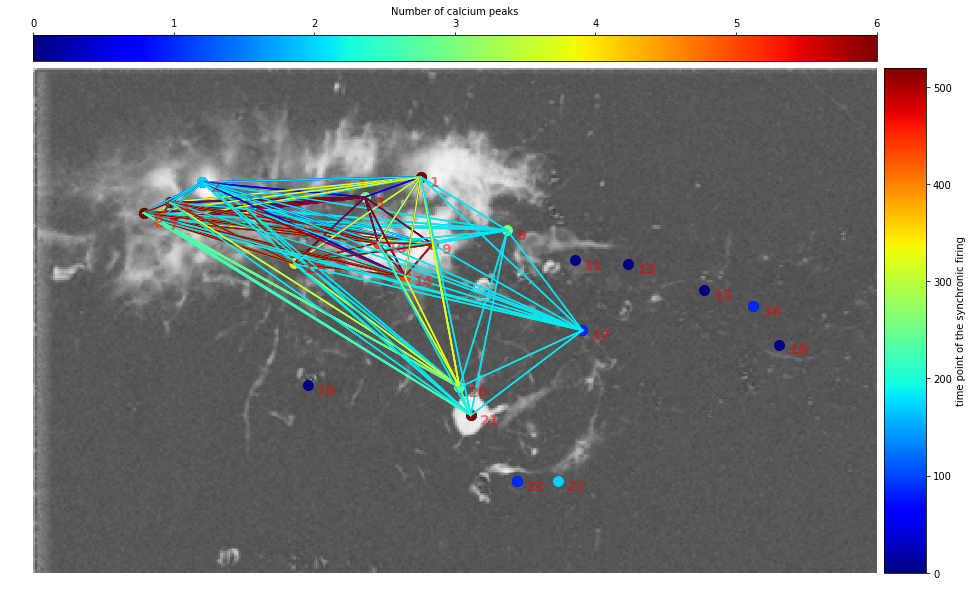

In [30]:
# sync_time is the window used around each peak to calculate synchronicity.
# Using sea_peak, you can sea the result of the detect_peak function on specific traces.

indexes, sync, peak_value = find_sync(d, meta, ch2_corr, regions_ch2, 
                            labels, cell_position, sync_time=sync_time, 
                            show=True, sea_peak = 1, roi = False,
                            tmin = 0, tmax = -1, dmin = 40, dmax = 50,
                            save=False, path=path)

# Convert data into a Pandas dataframe - Tabular data

If the argument save is equal to True, then the result will be save as an excel file. 

In [31]:
df, df1 = to_df(indexes,sync, peak_value,d, meta, save = False, path=path)

In [33]:
df1.head()

,0.0,0.7,1.5,2.2,3.0,3.7,4.5,5.2,5.9,6.7,...,513.0,513.7,514.5,515.2,516.0,516.7,517.5,518.2,518.9,519.7
1,1.413570,1.141702,1.005582,0.805387,0.779959,0.737833,0.594369,0.547617,0.574446,0.490329,...,1.017324,0.867267,0.826045,0.519872,0.390805,0.423205,0.477149,0.450203,0.357904,0.296711
2,0.148398,-0.057362,-0.126730,-0.099148,0.010701,0.069155,-0.007288,0.030810,0.111207,0.071492,...,0.073646,0.064312,0.071333,0.064642,0.126477,0.065594,0.056883,0.093826,0.047481,0.065907
3,0.019783,-0.039891,0.230005,0.099835,0.032035,0.141374,0.029402,0.162516,-0.009668,0.013967,...,0.284863,0.460421,0.323066,0.406429,0.296366,0.358337,0.272413,0.212651,0.342046,0.224191
4,-0.048293,0.026285,0.065729,0.153399,0.076807,0.178508,-0.010377,0.022119,0.004063,-0.043538,...,3.491886,2.910552,3.290300,2.945187,2.964136,2.889582,3.067637,2.923166,2.929231,2.833438
5,-0.007825,-0.151156,-0.024738,0.116567,0.244199,0.009080,0.064050,0.120025,-0.017608,0.170853,...,0.335596,0.228328,0.185022,0.205800,0.201707,0.165024,0.207550,0.198186,0.168180,0.167680
